In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import seaborn as sns
import glob
import pickle
from collections import defaultdict
from Bio.Seq import Seq

## Load GC trees

In [2]:
results = glob.glob("../nextflow/results/*")[-1]
results

'../nextflow/results/2022-04-01'

In [54]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
    if key.startswith("mouse7") or key.startswith("mouse8"):
        print(f"skipping 10-week {key}")
        continue
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

skipping 10-week mouse7_GC90
skipping 10-week mouse7_GC91
skipping 10-week mouse7_GC92
skipping 10-week mouse7_GC93
skipping 10-week mouse8_GC84
skipping 10-week mouse8_GC85
skipping 10-week mouse8_GC86
skipping 10-week mouse8_GC87
skipping 10-week mouse8_GC88
skipping 10-week mouse8_GC89
loaded 67 GC trees


## 5mer mutability model

In [31]:
mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence
igh_frame = 1
igk_frame = 1
igk_idx = 336

naive_igh_aa = aa(naive[:igk_idx], igh_frame)
naive_igk_aa = aa(naive[igk_idx:], igk_frame)

def mutate(sequence):
    sequence_H = "NN" + sequence[:igk_idx] + "NN"
    sequence_K = "NN" + sequence[igk_idx:] + "NN"
    # mutabilities of each nucleotide
    contexts = [sequence_H[(i - 2) : (i + 3)]
                    for i in range(2, len(sequence_H) - 2)
                   ] + [sequence_K[(i - 2) : (i + 3)]
                        for i in range(2, len(sequence_K) - 2)
                       ]
    mutabilities = np.array([mutability[context] for context in contexts])
    i = np.random.choice(len(mutabilities), p=mutabilities / sum(mutabilities))
    sequence = sequence[:i] + np.random.choice(substitution.columns, p=substitution.loc[contexts[i]].fillna(0)) + sequence[(i + 1):]
    return sequence

def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

## DMS data

In [32]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


In [34]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon
site_scFv,,,,
1,E,H,1,GAG
2,V,H,2,GTG
3,Q,H,3,CAG
4,L,H,4,CTT
5,Q,H,5,CAG
...,...,...,...,...
231,L,L,120,CTA
232,E,L,121,GAA
233,I,L,122,ATA


In [36]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Simulate expression-matched trees

In [60]:
sim_trees = defaultdict(lambda: ([], []))
expression_threshold = 0.1 #np.inf
for gc, tree in trees.items():
    print(f"GC {gc}")
    for expression_matching in (False,):#, True):
        replicate = 1
        dead = False
        while replicate <= 10:
            print(f"  {'expression matched ' if expression_matching else ''}replicate {replicate}", end="   \r")
            new_tree = tree.tree.copy()
            for node, node_new in zip(tree.tree.traverse(strategy="preorder"), new_tree.traverse(strategy="preorder")):
                assert node.name == node_new.name
                if not node.is_root():
                    success = False
                    closest = np.inf
                    for tries in range(100):
                        node_new.sequence = node_new.up.sequence
                        for _ in range(int(node.dist)):
                            node_new.sequence = mutate(node_new.sequence)
                            igh_aa = aa(node_new.sequence[:igk_idx], igh_frame)
                            igk_aa = aa(node_new.sequence[igk_idx:], igk_frame)
                            igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
                            igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
                            all_mutations = igh_mutations + igk_mutations
                            if any("*" in x for x in all_mutations):
                                node_new.delta_bind = None
                                node_new.delta_expr = None
                                node_new.delta_psr = None
                            else:
                                node_new.delta_bind = dms_df.delta_bind[all_mutations].sum()
                                node_new.delta_expr = dms_df.delta_expr[all_mutations].sum()
                                node_new.delta_psr = dms_df.delta_psr[all_mutations].sum()
                        # note: selecting on additive expression estimate
                        if node_new.delta_expr is None:
                            continue
                        delta = np.abs(node_new.delta_expr - node.delta_expr)
                        if delta < closest:
                            closest = delta
                            closest_seq = node_new.sequence
                            closest_delta_bind = node_new.delta_bind
                            closest_delta_expr = node_new.delta_expr
                            closest_delta_psr = node_new.delta_psr
                        if not expression_matching or delta < expression_threshold:
                            success = True
                            break
                    if not success:
                        node_new.sequence = closest_seq
                        node_new.delta_bind = closest_delta_bind
                        node_new.delta_expr = closest_delta_expr
                        node_new.delta_psr = closest_delta_psr

            sim_trees[gc][expression_matching].append(new_tree)
            replicate += 1
        print()

GC mouse1_GC1
  replicate 10   
GC mouse1_GC2
  replicate 10   
GC mouse1_GC3
  replicate 10   
GC mouse1_GC4
  replicate 10   
GC mouse1_GC5
  replicate 10   
GC mouse1_GC6
  replicate 10   
GC mouse1_GC7
  replicate 10   
GC mouse1_GC11
  replicate 10   
GC mouse1_GC12
  replicate 10   
GC mouse1_GC13
  replicate 10   
GC mouse1_GC14
  replicate 10   
GC mouse1_GC15
  replicate 10   
GC mouse1_GC16
  replicate 10   
GC mouse1_GC17
  replicate 10   
GC mouse1_GC18
  replicate 10   
GC mouse1_GC19
  replicate 10   
GC mouse1_GC20
  replicate 10   
GC mouse2_GC21
  replicate 10   
GC mouse2_GC22
  replicate 10   
GC mouse2_GC23
  replicate 10   
GC mouse2_GC24
  replicate 10   
GC mouse2_GC25
  replicate 10   
GC mouse2_GC26
  replicate 10   
GC mouse2_GC28
  replicate 10   
GC mouse2_GC29
  replicate 10   
GC mouse2_GC30
  replicate 10   
GC mouse2_GC31
  replicate 10   
GC mouse2_GC32
  replicate 10   
GC mouse2_GC34
  replicate 10   
GC mouse2_GC38
  replicate 10   
GC mouse2_GC39
  

In [ ]:
# sim_df = pd.DataFrame()
# replicate = 1
# delta_expr_threshold = -3
# fitness_transition = 10
# while replicate < 100:
#     print(f"replicate {replicate + 1}", end="   \r")
#     sequence = naive
#     n_mutations = 0
#     rep_df = pd.DataFrame()
#     dead = False
#     while n_mutations < 11:
#         if n_mutations:
#             new_sequence = mutate(sequence)
#         else:
#             new_sequence = sequence
# #         igh_aa = aa(new_sequence[:igk_idx], igh_frame)
# #         igk_aa = aa(new_sequence[igk_idx:], igk_frame)
# #         igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
# #         igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")
# #         all_mutations = igh_mutations + igk_mutations
#         all_mutations = igh_mutations + igk_mutations
#         tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(new_sequence))).detach() - tdms_prediction_naive
#         if np.random.rand() < expit(-fitness_transition * (tdms_prediction[1] - delta_expr_threshold)):
#             dead=True
#             break
#         sequence = new_sequence
#         new_row = pd.Series({"delta_bind": tdms_prediction[0].item(),
#                              "delta_expr": tdms_prediction[1].item(),
#                              "n_mutations": n_mutations,
#                              "replicate": replicate})
#         rep_df = rep_df.append(new_row, ignore_index=True, verify_integrity=True)
#         n_mutations += 1
#     if not dead:
#         sim_df = sim_df.append(rep_df, ignore_index=True, verify_integrity=True)
#         replicate += 1
# sim_df

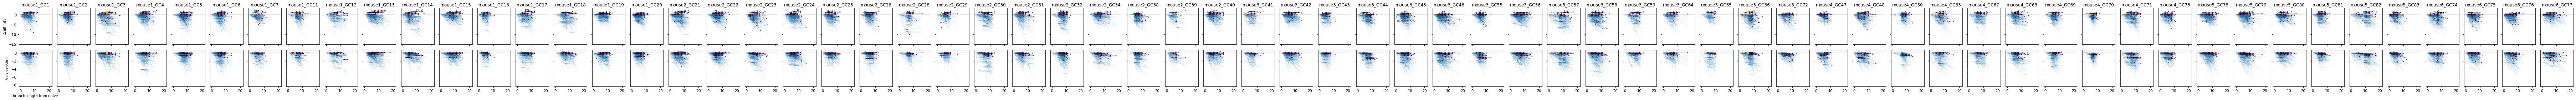

In [63]:
# fig, axes = plt.subplots(3, len(trees), figsize=(1.5 * len(trees), 6), sharex=True, sharey="row")
# note: skipping psr and some GCs
fig, axes = plt.subplots(2, len(trees), figsize=(1.5 * len(trees), 4), sharex=True, sharey="row")

color_by = "LBR" #LBI

vmin_LB = 0
vmax_LB = 10

for i, (phenotype, phenotype_label) in enumerate(zip(("delta_bind", "delta_expr"
                                                      ),
                                                     (r"$\Delta$ affinity", r"$\Delta$ expression"
                                                      )
                                                     )):
    for j, (gc, tree) in enumerate(trees.items()):
        points = []
        lines = []
        colors = []
        
#         if j == 4: break
        
        for node in tree.tree.traverse():
            points.append((tree.tree.get_distance(node),
                           getattr(node, phenotype),
                           1 + 5 * node.abundance,
                           getattr(node, color_by)))
            if node.up is not None:
                lines.append([(tree.tree.get_distance(node.up), getattr(node.up, phenotype)),
                              (tree.tree.get_distance(node), getattr(node, phenotype))])
            colors.append(getattr(node, color_by))

        sim_lines = []
        for sim_idx, sim_tree in enumerate(sim_trees[gc][0]):
            for node in sim_tree.traverse():
                if node.up is not None:
                    sim_lines.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
                                      (sim_tree.get_distance(node), getattr(node, phenotype))])
        sim_lines_matched = []
        for sim_idx, sim_tree in enumerate(sim_trees[gc][1]):
            for node in sim_tree.traverse():
                if node.up is not None:
                    sim_lines_matched.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
                                              (sim_tree.get_distance(node), getattr(node, phenotype))])
        lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
        sim_lc = mc.LineCollection(sim_lines, colors="C0", linewidths=1, alpha=0.1, zorder=2)
        sim_matched_lc = mc.LineCollection(sim_lines_matched, colors="C1", linewidths=1, alpha=0.1, zorder=2)

        ax = axes[i, j]
        ax.axhline(0, c="k", ls="--", lw=0.25, zorder=1)
#         if phenotype == "delta_expr":
#             ax.axhline(delta_expr_threshold, c="r", ls="--", lw=0.25, zorder=1)
        ax.add_collection(lc)
        ax.add_collection(sim_lc)
        ax.add_collection(sim_matched_lc)
        ax.scatter(*zip(*points), cmap="viridis", vmin=vmin_LB, vmax=vmax_LB, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4)
        if i == 0:
            ax.set_title(gc)
        ax.set_xlabel(None)
#         break
    axes[i, 0].set_ylabel(phenotype_label)
axes[-1, 0].set_xlabel("branch length from naive")
plt.tight_layout()
plt.savefig("output/plots/phenotype-trajectories.pdf")
plt.show()

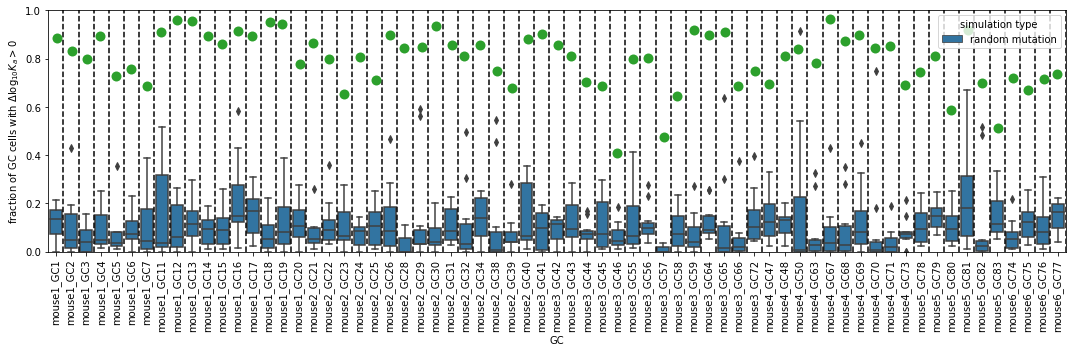

In [61]:
def tree_stat(tree, threshold=0):
    total = 0
    tail_count = 0
    for node in tree.traverse():
        total += node.abundance
        if node.delta_bind > threshold:
            tail_count += node.abundance
    return tail_count / total

dat = []
threshold = 0 #np.log10(2)
for gc, tree in trees.items():
    dat.append([gc, False, None, tree_stat(tree.tree, threshold)])
    for rep_tree in sim_trees[gc][0]:
        dat.append([gc, True, "random mutation", tree_stat(rep_tree, threshold)])
    for rep_tree in sim_trees[gc][1]:
        dat.append([gc, True, "expression matched", tree_stat(rep_tree, threshold)])

stat_df = pd.DataFrame(dat, columns=["GC", "simulation", "simulation type", fr"fraction of GC cells with $\Delta\log_{{10}}K_a>{threshold}$"])    

plt.figure(figsize=(15, 5))
g = sns.boxplot(data=stat_df.loc[stat_df.simulation == True],
                x="GC", y=fr"fraction of GC cells with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type",
                dodge=True
#                    split=True, inner="stick"
               )
sns.stripplot(data=stat_df.loc[stat_df.simulation == False],
              x="GC", y=fr"fraction of GC cells with $\Delta\log_{{10}}K_a>{threshold}$",
              color="C2", size=10)
plt.ylim(0, 1)
for item in g.get_xticklabels():
    item.set_rotation(90)
for tick_pos in g.get_xticks():
    plt.axvline(tick_pos + 0.5, c="k", ls="--")
plt.tight_layout()
plt.savefig("output/plots/phenotype-trajectories.summary.pdf")
plt.show()

# sns.displot(data=stat_df, col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4)
# sns.displot(data=stat_df.loc[stat_df.simulation == False], col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4, rug=True)
# # plt.savefig("output/plots/selection_stat.pdf")
# plt.show()

In [46]:
stat_df

,GC,simulation,simulation type,fraction of GC cells with $\Delta\log_{10}K_a>0$
0,mouse1_GC1,False,None,0.887640
1,mouse1_GC1,True,random mutation,0.022472
2,mouse1_GC1,True,expression matched,0.011236
3,mouse1_GC2,False,None,0.833333
4,mouse1_GC2,True,random mutation,0.166667
...,...,...,...,...
196,mouse6_GC76,True,random mutation,0.061728
197,mouse6_GC76,True,expression matched,0.123457
198,mouse6_GC77,False,None,0.736842
199,mouse6_GC77,True,random mutation,0.026316


In [55]:
dat = []
for mousegc, tree in trees.items():
    mouse, gc = mousegc.split("_")
    mouse = mouse.lstrip("mouse")
    gc = gc.lstrip("GC")
    
    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in tree.tree.children]
    dom_score = max(clade_sizes) / sum(clade_sizes)
    max_LBR = np.nanmax([node.LBR for node in tree.tree.traverse()])
    
    for node in tree.tree.traverse():
        if node.abundance:
            dat.append([mouse, gc, node.name, node.abundance, tree.tree.get_distance(node), node.delta_bind, node.delta_expr])

cell_df = pd.DataFrame(dat, columns=("mouse", "GC", "id", "abundance", "divergence", r"$\Delta$ affinity", r"$\Delta$ expression"))

# cell_df.to_csv("/Users/wdewitt/Downloads/cell_distributions.csv")
cell_df

,mouse,GC,id,abundance,divergence,$\Delta$ affinity,$\Delta$ expression
0,1,1,seq37,1,4.0,-0.06082,0.14827
1,1,1,seq47,1,11.0,-3.45668,-1.05627
2,1,1,seq56,1,1.0,-0.80796,-0.15104
3,1,1,seq26,1,3.0,-1.52301,-0.34882
4,1,1,seq57,1,9.0,-9.09012,-0.81985
...,...,...,...,...,...,...,...
4486,6,77,seq37,3,8.0,1.08960,-0.12466
4487,6,77,seq19,1,9.0,0.75399,-0.72151
4488,6,77,seq40,1,8.0,0.71905,-0.86401
4489,6,77,seq56,1,9.0,1.13203,-0.13537


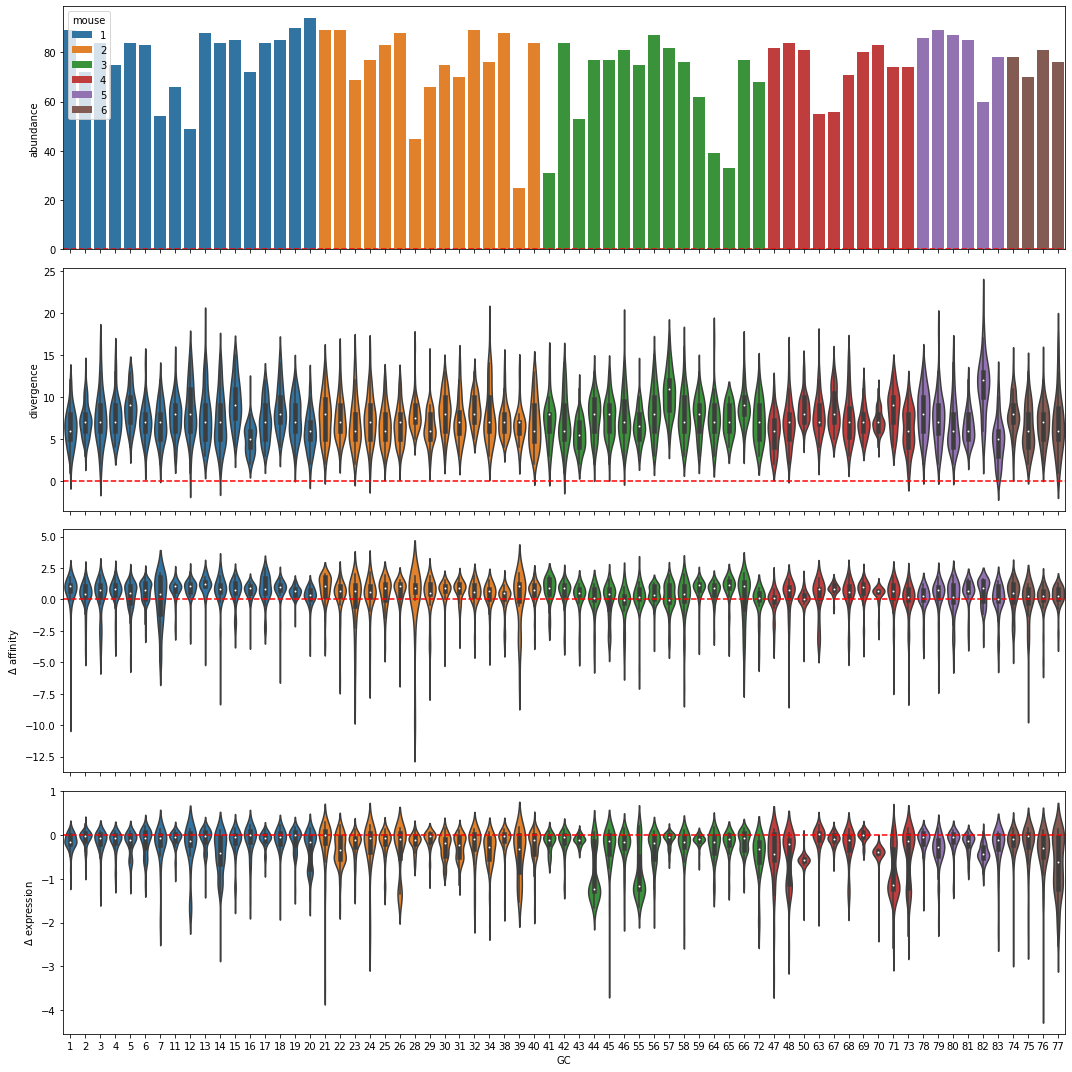

In [56]:
fig, axes = plt.subplots(4, 1, sharex="col", figsize=(15, 15))

sns.barplot(data=cell_df, x="GC", hue="mouse", y="abundance", ci=False, estimator=sum, dodge=False, ax=axes[0])
sns.move_legend(axes[0], "upper left")
axes[0].set(xlabel=None)
axes[0].axhline(0, ls="--", c="red")

ax = sns.violinplot(data=cell_df, x="GC", hue="mouse", y="divergence", weights="abundance", dodge=False, legend=False, ax=axes[1])
axes[1].get_legend().remove()
axes[1].set(xlabel=None)
axes[1].axhline(0, ls="--", c="red")

ax = sns.violinplot(data=cell_df, x="GC", hue="mouse", y=r"$\Delta$ affinity", weights="abundance", dodge=False, legend=False, ax=axes[2])
axes[2].get_legend().remove()
axes[2].set(xlabel=None)
axes[2].axhline(0, ls="--", c="red")

ax = sns.violinplot(data=cell_df, x="GC", hue="mouse", y=r"$\Delta$ expression", weights="abundance", dodge=False, legend=False, ax=axes[3])
axes[3].get_legend().remove()
axes[3].axhline(0, ls="--", c="red")

plt.tight_layout()
plt.savefig("output/plots/phenotype-trajectories.cell-summary.pdf")
plt.show()